# **Final Project: AI-Powered Image Wizard**

* Name: **Aktham Almomani**
* Date: **12/09/2024**

## **Stage 3: Colorization**

## **Introduction**

The colorization stage of the AI-Powered Image Wizard is designed to transform grayscale (black-and-white) images into vivid, realistic color versions. Leveraging advanced machine learning techniques, this stage enables the AI to understand image context, structure, and textures to recreate accurate and visually appealing color representations. Whether it's restoring old photographs or adding life to artistic sketches, the colorization stage uses deep neural networks to breathe color into every pixel.

## **Dataset**

In this pipeline, we utilize the COCO Dataset (Common Objects in Context) — a large-scale, richly annotated dataset. It includes a diverse range of images with objects and environments commonly encountered in real life. This diversity allows our AI to learn colorization patterns for a wide variety of objects, from faces to natural landscapes, making the model highly versatile and robust for real-world applications.

By combining the COCO dataset's visual richness with state-of-the-art deep learning techniques, the colorization stage ensures highly detailed and contextually appropriate color restoration for any grayscale image.

## **Import Necessary Libraries**

In [ ]:
import tensorflow as tf
import os
import random
from pathlib import Path
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from pycocotools.coco import COCO
from tqdm import tqdm
from pycocotools.coco import COCO
import requests
import matplotlib.pyplot as plt
import shutil
from sklearn.model_selection import train_test_split


In [ ]:
print("CUDA available:", torch.cuda.is_available())
print("Device count:", torch.cuda.device_count())
print("Current device:", torch.cuda.current_device() if torch.cuda.is_available() else "No GPU detected")
print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")

CUDA available: True
Device count: 1
Current device: 0
Device name: Tesla T4


## **Dataset Download**

In [ ]:
# Download COCO Annotations
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip annotations_trainval2017.zip -d ./coco_annotations

--2024-12-07 23:37:49--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.61.161, 52.217.50.28, 52.217.123.153, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.61.161|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annotations_trainva 100%[===================>] 241.19M  16.4MB/s    in 16s     

2024-12-07 23:38:05 (15.0 MB/s) - ‘annotations_trainval2017.zip’ saved [252907541/252907541]

Archive:  annotations_trainval2017.zip
  inflating: ./coco_annotations/annotations/instances_train2017.json  
  inflating: ./coco_annotations/annotations/instances_val2017.json  
  inflating: ./coco_annotations/annotations/captions_train2017.json  
  inflating: ./coco_annotations/annotations/captions_val2017.json  
  inflating: ./coco_annotations/annotations/person_keypoints_train2017.json

In [ ]:
# Specify paths:
data_dir = "./coco_images"
os.makedirs(data_dir, exist_ok=True)

# Initialize COCO API:
coco = COCO('./coco_annotations/annotations/instances_val2017.json')

# Get image IDs and metadata:
img_ids = coco.getImgIds()[:100]  # Select the first 100 images
images = coco.loadImgs(img_ids)

# Download images:
for img in images:
    img_data = requests.get(img['coco_url']).content
    with open(os.path.join(data_dir, img['file_name']), 'wb') as handler:
        handler.write(img_data)

print(f"Downloaded {len(images)} images to {data_dir}")

loading annotations into memory...
Done (t=0.72s)
creating index...
index created!
Downloaded 100 images to ./coco_images


## **Creating Grayscale Images from Colored Images Using COCO Dataset**

The process of creating grayscale images from colored images is a crucial preprocessing step in many computer vision tasks, such as colorization and image inpainting. By separating the original colored images and their grayscale counterparts, we can effectively build datasets that allow AI models to learn how to reconstruct or enhance images.

This task uses a directory of COCO dataset images to generate two sets of images:

* Grayscale Images: These are created by converting the colored images into single-channel intensity values, removing the color information while retaining structural details.
* Colored Images: The original images are stored as-is to serve as the ground truth for supervised training tasks.

By organizing these images into separate directories, we enable efficient visualization and comparison of grayscale-to-color transformations. This step not only prepares the dataset but also provides a foundation for exploring advanced tasks like AI-driven colorization and restoration.

In [ ]:
# Input directory containing downloaded COCO images
data_dir = "./coco_images"

# Directories for grayscale and color images
gray_dir = "./gray_images"
color_dir = "./color_images"

# Create output directories if they don't already exist
os.makedirs(gray_dir, exist_ok=True)
os.makedirs(color_dir, exist_ok=True)

# Iterate through the images in the input directory
for img_file in os.listdir(data_dir):
    img_path = os.path.join(data_dir, img_file)

    try:
        # Load the image
        img = Image.open(img_path).convert("RGB")  # Ensure it's in RGB format

        # Save the original (colored) image to the color directory
        img.save(os.path.join(color_dir, img_file))

        # Convert the image to grayscale
        gray_img = img.convert("L")

        # Save the grayscale image to the grayscale directory
        gray_img.save(os.path.join(gray_dir, img_file))
    except Exception as e:
        print(f"Error processing {img_file}: {e}")

In [ ]:
# Directories for grayscale and colored images
gray_dir = "./gray_images"
color_dir = "./color_images"

# Count images
num_gray_images = len(os.listdir(gray_dir))
num_color_images = len(os.listdir(color_dir))

print(f"Number of grayscale images: {num_gray_images}")
print(f"Number of colored images: {num_color_images}")

Number of grayscale images: 100
Number of colored images: 100


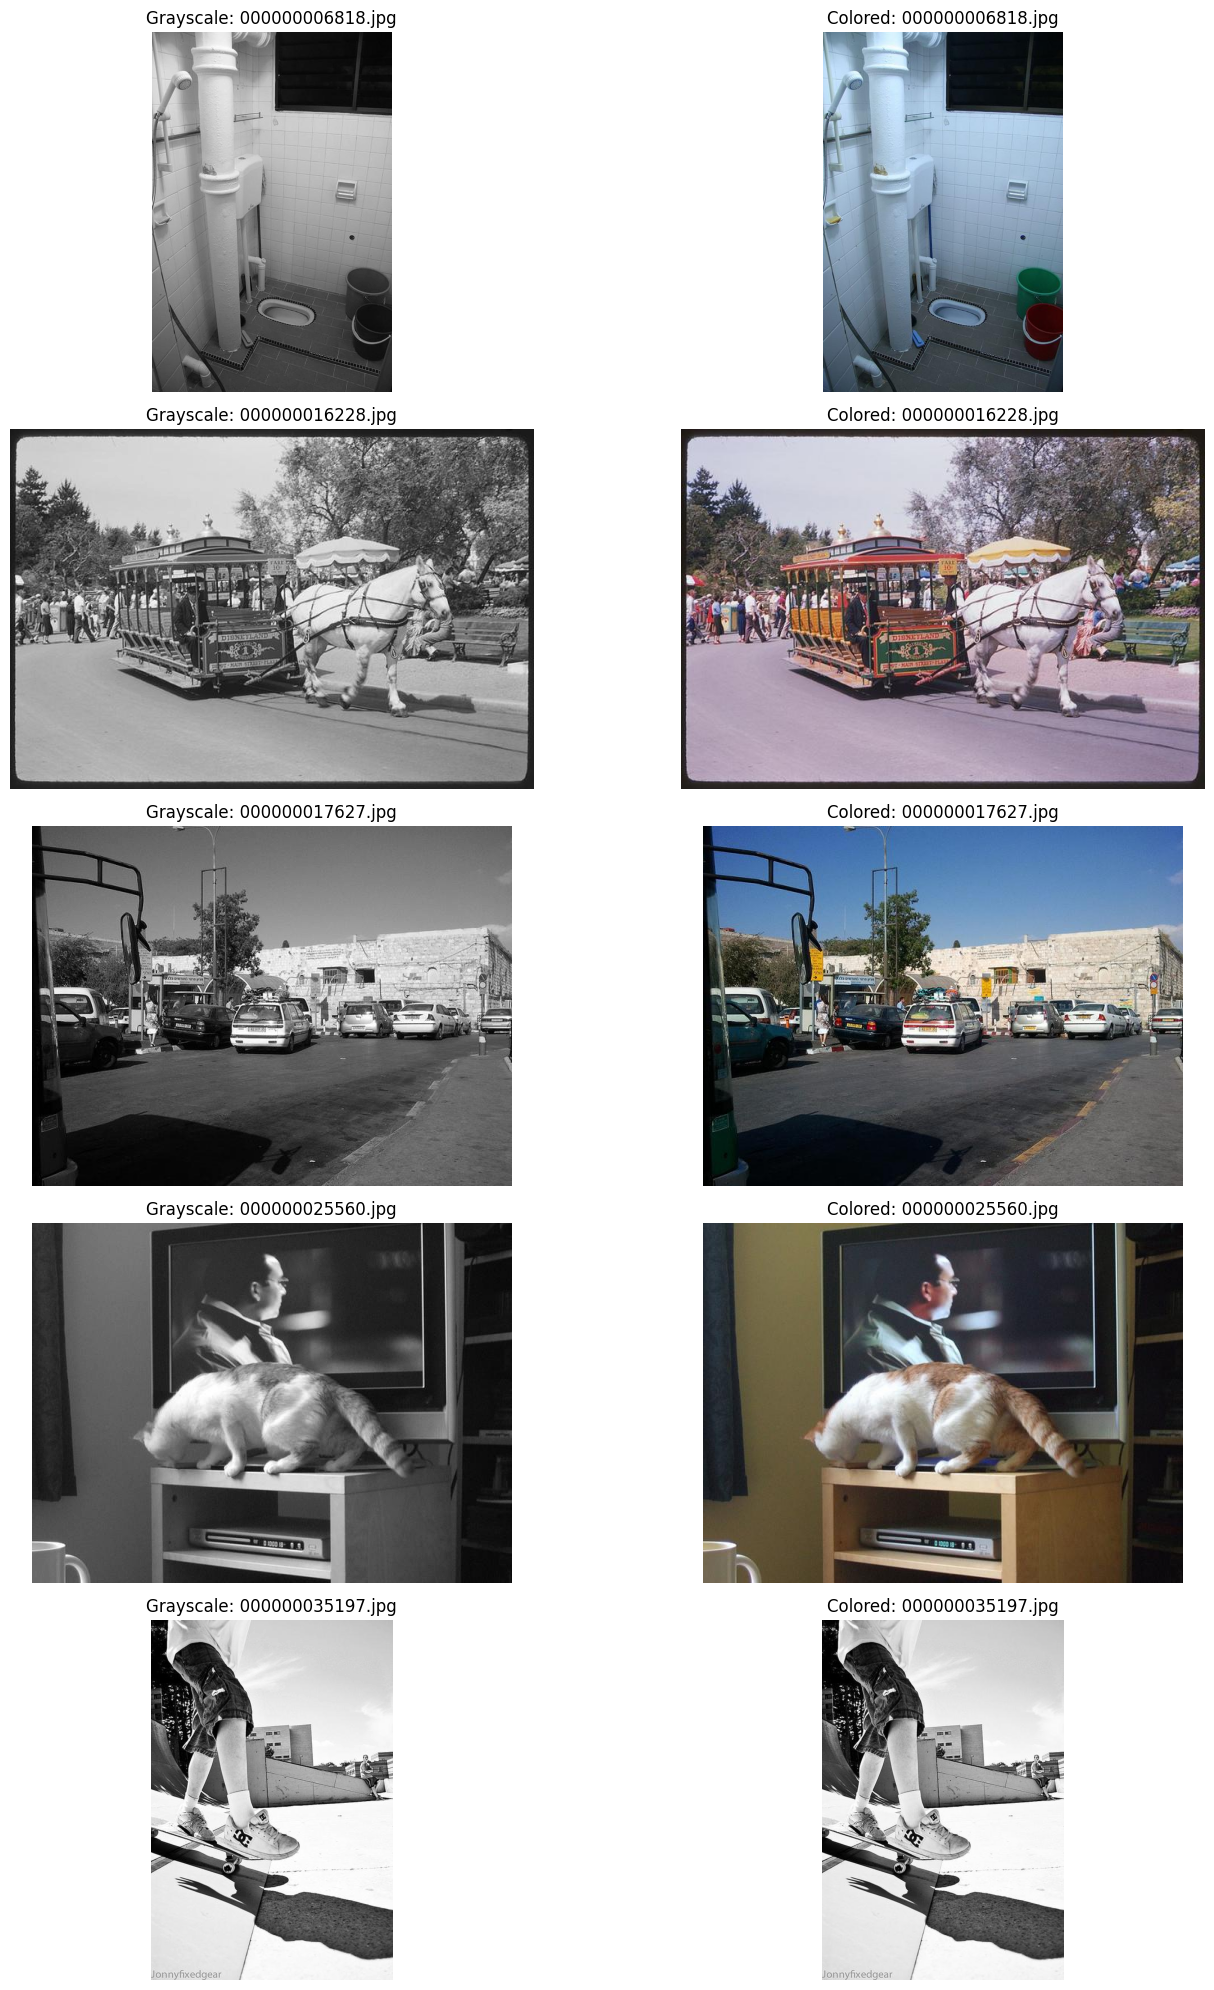

In [ ]:
# Get the list of image files
gray_images = sorted(os.listdir(gray_dir))
color_images = sorted(os.listdir(color_dir))

# Visualize 5 image pairs
num_pairs = min(5, len(gray_images), len(color_images))  # Ensure there are at least 5 images

plt.figure(figsize=(15, 20))
for i in range(num_pairs):
    gray_path = os.path.join(gray_dir, gray_images[i])
    color_path = os.path.join(color_dir, color_images[i])

    # Load images
    gray_img = Image.open(gray_path)
    color_img = Image.open(color_path)

    # Plot grayscale image
    plt.subplot(num_pairs, 2, 2 * i + 1)
    plt.imshow(gray_img, cmap="gray")
    plt.axis("off")
    plt.title(f"Grayscale: {gray_images[i]}")

    # Plot colored image
    plt.subplot(num_pairs, 2, 2 * i + 2)
    plt.imshow(color_img)
    plt.axis("off")
    plt.title(f"Colored: {color_images[i]}")

plt.tight_layout()
plt.show()

In [ ]:
# Directories
gray_dir = "./gray_images"
color_dir = "./color_images"

# Output directories
train_gray_dir = "./train/gray"
val_gray_dir = "./val/gray"
train_color_dir = "./train/color"
val_color_dir = "./val/color"

# Create output directories
os.makedirs(train_gray_dir, exist_ok=True)
os.makedirs(val_gray_dir, exist_ok=True)
os.makedirs(train_color_dir, exist_ok=True)
os.makedirs(val_color_dir, exist_ok=True)

# Get image filenames
gray_images = sorted(os.listdir(gray_dir))
color_images = sorted(os.listdir(color_dir))

# Ensure files match in both directories
assert len(gray_images) == len(color_images), "Mismatch between gray and color image counts."

# Split into training and validation sets
train_gray, val_gray, train_color, val_color = train_test_split(
    gray_images, color_images, test_size=0.2, random_state=42
)

# Move files to respective directories
for img_file in train_gray:
    shutil.move(os.path.join(gray_dir, img_file), os.path.join(train_gray_dir, img_file))
for img_file in val_gray:
    shutil.move(os.path.join(gray_dir, img_file), os.path.join(val_gray_dir, img_file))
for img_file in train_color:
    shutil.move(os.path.join(color_dir, img_file), os.path.join(train_color_dir, img_file))
for img_file in val_color:
    shutil.move(os.path.join(color_dir, img_file), os.path.join(val_color_dir, img_file))

print("Dataset split completed!")
print(f"Training set: {len(train_gray)} grayscale images, {len(train_color)} colored images.")
print(f"Validation set: {len(val_gray)} grayscale images, {len(val_color)} colored images.")

Dataset split completed!
Training set: 80 grayscale images, 80 colored images.
Validation set: 20 grayscale images, 20 colored images.


In [ ]:
# Define directories
train_gray_dir = "./train/gray"
train_color_dir = "./train/color"
val_gray_dir = "./val/gray"
val_color_dir = "./val/color"

# Image size
IMG_SIZE = (256, 256)

def load_image(image_path, color=False):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3 if color else 1)
    img = tf.image.resize(img, IMG_SIZE)
    img = img / 255.0  # Normalize to [0, 1]
    return img

def create_dataset(gray_dir, color_dir):
    gray_paths = sorted([os.path.join(gray_dir, f) for f in os.listdir(gray_dir)])
    color_paths = sorted([os.path.join(color_dir, f) for f in os.listdir(color_dir)])

    # Create a dataset
    gray_images = tf.data.Dataset.from_tensor_slices(gray_paths).map(lambda x: load_image(x, color=False))
    color_images = tf.data.Dataset.from_tensor_slices(color_paths).map(lambda x: load_image(x, color=True))

    # Pair grayscale and color images
    dataset = tf.data.Dataset.zip((gray_images, color_images))
    return dataset

# Create training and validation datasets
train_dataset = create_dataset(train_gray_dir, train_color_dir).batch(32).shuffle(1000)
val_dataset = create_dataset(val_gray_dir, val_color_dir).batch(32)

## **Downloading and Using DeOldify: A State-of-the-Art Model for Image Colorization**

**DeOldify** is a deep learning-based project that leverages modern neural networks to colorize black-and-white images and videos with stunning results. Developed using **PyTorch** and **FastAI**, **DeOldify** is widely recognized for its artistic and photo-realistic image colorization capabilities.

**Why Choose DeOldify for Colorization?**

* High-Quality Results: DeOldify produces visually appealing and vibrant colorized images. It balances realism and creativity, making it suitable for artistic and professional use.

* Pretrained State-of-the-Art Models:

  * Artistic Model: Focuses on adding vibrant, high-saturation colors for dramatic and visually striking results.
  * Stable Model: Designed for realism, making it suitable for archival and historical image restoration.

* Flexibility: DeOldify allows customization through parameters like the render factor, enabling users to control the level of detail and color intensity.

* Ease of Use: The model comes with pretrained weights (ColorizeArtistic_gen.pth and others) and tools for loading, processing, and colorizing images or videos without requiring extensive knowledge of machine learning.

* Versatility: DeOldify supports:

  * Grayscale photo colorization
  * Old video restoration
  * Enhancing faded or partially colored media

* Community and Open-Source Support: As an open-source project, DeOldify has an active community and comprehensive documentation, making it accessible for developers and enthusiasts.

In [ ]:
!pwd

/content


In [ ]:
!ls -l

total 247012
-rw-r--r-- 1 root root 252907541 Jul 10  2018 annotations_trainval2017.zip
drwxr-xr-x 3 root root      4096 Dec  7 23:38 coco_annotations
drwxr-xr-x 2 root root      4096 Dec  7 23:40 coco_images
drwxr-xr-x 2 root root      4096 Dec  7 23:42 color_images
drwxr-xr-x 2 root root      4096 Dec  7 23:42 gray_images
drwxr-xr-x 1 root root      4096 Dec  5 14:24 sample_data
drwxr-xr-x 4 root root      4096 Dec  7 23:42 train
drwxr-xr-x 4 root root      4096 Dec  7 23:42 val


In [ ]:
!git clone https://github.com/jantic/DeOldify.git
%cd DeOldify
!pip install -r requirements-colab.txt


Cloning into 'DeOldify'...
remote: Enumerating objects: 2620, done.
remote: Counting objects: 100% (274/274), done.
remote: Compressing objects: 100% (194/194), done.
remote: Total 2620 (delta 93), reused 212 (delta 73), pack-reused 2346 (from 1)
Receiving objects: 100% (2620/2620), 69.71 MiB | 16.49 MiB/s, done.
Resolving deltas: 100% (1176/1176), done.
/content/DeOldify
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.1/172.1 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 631.4/631.4 kB 44.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.3/237.3 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 98.4 MB/s eta 0:00:00
  Created wheel for imgaug: filename=imgaug-0.2.6-py3-none-any.whl size=654004 sha256=62f14270a8a466120675e7e80d5e6a6f14cdd9a9066145e2ce4a

In [ ]:
!mkdir 'models'
!wget https://data.deepai.org/deoldify/ColorizeArtistic_gen.pth -P models


mkdir: cannot create directory ‘models’: File exists
--2024-12-07 23:43:41--  https://data.deepai.org/deoldify/ColorizeArtistic_gen.pth
Resolving data.deepai.org (data.deepai.org)... 84.17.38.232, 2400:52e0:1500::1095:1
Connecting to data.deepai.org (data.deepai.org)|84.17.38.232|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 255144681 (243M) [application/octet-stream]
Saving to: ‘models/ColorizeArtistic_gen.pth’

ColorizeArtistic_ge 100%[===================>] 243.32M  4.96MB/s    in 49s     

2024-12-07 23:44:31 (4.92 MB/s) - ‘models/ColorizeArtistic_gen.pth’ saved [255144681/255144681]



In [ ]:
!pwd

/content/DeOldify


In [ ]:
!ls -l

total 388
-rw-r--r--  1 root root  7379 Dec  7 23:43 ColorFIDBenchmarkArtistic.ipynb
-rw-r--r--  1 root root 15025 Dec  7 23:43 ColorizeTrainingArtistic.ipynb
-rw-r--r--  1 root root 15033 Dec  7 23:43 ColorizeTrainingStable.ipynb
-rw-r--r--  1 root root 18892 Dec  7 23:43 ColorizeTrainingStableLargeBatch.ipynb
-rw-r--r--  1 root root 12035 Dec  7 23:43 ColorizeTrainingVideo.ipynb
-rw-r--r--  1 root root 27053 Dec  7 23:43 ColorizeTrainingWandb.ipynb
drwxr-xr-x  2 root root  4096 Dec  7 23:43 deoldify
-rw-r--r--  1 root root   333 Dec  7 23:43 environment.yml
drwxr-xr-x 10 root root  4096 Dec  7 23:43 fastai
drwxr-xr-x  2 root root  4096 Dec  7 23:43 fid
-rw-r--r--  1 root root 79684 Dec  7 23:43 ImageColorizerArtisticTests.ipynb
-rw-r--r--  1 root root  7865 Dec  7 23:43 ImageColorizerColab.ipynb
-rw-r--r--  1 root root  7810 Dec  7 23:43 ImageColorizerColabStable.ipynb
-rw-r--r--  1 root root  5670 Dec  7 23:43 ImageColorizer.ipynb
-rw-r--r--  1 root root 78929 Dec  7 23:43 ImageColo

In [ ]:
!ls -l models/


total 249168
-rw-r--r-- 1 root root 255144681 Dec 18  2022 ColorizeArtistic_gen.pth


In [ ]:
import torch
from deoldify.visualize import get_image_colorizer


In [ ]:
# Check device availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("Device count:", torch.cuda.device_count())
print("Current device:", torch.cuda.current_device() if torch.cuda.is_available() else "No GPU detected")
print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")


CUDA available: True
Device count: 1
Current device: 0
Device name: Tesla T4


In [ ]:
print(dir(colorizer))


['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_clean_mem', '_get_image_from_url', '_get_num_rows_columns', '_open_pil_image', '_plot_comparison', '_plot_image', '_plot_solo', '_save_result_image', 'filter', 'get_transformed_image', 'plot_transformed_image', 'plot_transformed_image_from_url', 'results_dir']


In [ ]:
!ls -l

total 247016
-rw-r--r--  1 root root 252907541 Jul 10  2018 annotations_trainval2017.zip
drwxr-xr-x  3 root root      4096 Dec  7 23:38 coco_annotations
drwxr-xr-x  2 root root      4096 Dec  7 23:40 coco_images
drwxr-xr-x  2 root root      4096 Dec  7 23:42 color_images
drwxr-xr-x 11 root root      4096 Dec  7 23:45 DeOldify
drwxr-xr-x  2 root root      4096 Dec  7 23:42 gray_images
drwxr-xr-x  1 root root      4096 Dec  5 14:24 sample_data
drwxr-xr-x  4 root root      4096 Dec  7 23:42 train
drwxr-xr-x  4 root root      4096 Dec  7 23:42 val


In [ ]:
%cd train

/content/train


In [ ]:
!ls -l

total 8
drwxr-xr-x 2 root root 4096 Dec  7 23:42 color
drwxr-xr-x 2 root root 4096 Dec  7 23:42 gray


In [ ]:
%cd models

/content/DeOldify/models


In [ ]:
!ls -l


total 249168
-rw-r--r-- 1 root root 255144681 Dec 18  2022 ColorizeArtistic_gen.pth


In [ ]:
!ls /content/DeOldify/models


ColorizeArtistic_gen.pth  models


## **Colorization using DeOldify**

Colorization of grayscale images is a computer vision task that aims to add realistic and aesthetically pleasing colors to black-and-white images. This process transforms an image that lacks color information into a colorful representation that is visually engaging and informative. In this implementation, we utilize deep learning techniques, specifically the DeOldify model, to achieve high-quality image colorization with minimal manual intervention.

**Key Highlights of the Colorization Process:**

* Render Factor Tuning: The render factor is an adjustable parameter in DeOldify that allows fine-tuning of the colorization process. By varying this factor, you can control the saturation, vibrancy, and color intensity of the output images.

* Fully Automated Workflow: Once the directories are set up and the model is initialized, the entire process runs automatically, processing all images in the specified directory.

* Scalability: This method supports batch processing of multiple images, making it suitable for large datasets.

* Integration with Deep Learning Models: DeOldify leverages advanced deep learning techniques like GANs to create realistic and artistic colorizations by learning from massive datasets of color images.

In [ ]:
import os
os.chdir("/content/DeOldify")


In [ ]:
import os
from deoldify.visualize import get_image_colorizer

# Ensure the working directory is correct
os.chdir("/content/DeOldify")

# Verify that the model exists in the correct directory
model_path = "models/ColorizeArtistic_gen.pth"
if not os.path.exists(model_path):
    print(f"Model file not found at {model_path}. Downloading...")
    !wget https://data.deepai.org/deoldify/ColorizeArtistic_gen.pth -P models/

# Initialize the colorizer
print("Initializing the colorizer model...")
colorizer = get_image_colorizer(artistic=True)
print("Model initialized successfully.")


Initializing the colorizer model...
Model initialized successfully.


In [ ]:
# Directories
gray_dir = "/content/train/gray"  # Directory for grayscale images
colorized_dir = "/content/train/colorized_images"  # Directory for saving colorized images
original_color_dir = "/content/train/color"  # Directory for original colored images

os.makedirs(colorized_dir, exist_ok=True)

# Function to colorize an image and save it
def colorize_image(input_path, output_path, render_factor=35):
    try:
        print(f"Colorizing image: {input_path}")
        result_image = colorizer.get_transformed_image(
            path=input_path, render_factor=render_factor
        )
        result_image.save(output_path)  # Save the colorized image
    except Exception as e:
        print(f"Error while colorizing {input_path}: {e}")

# Process all grayscale images
for image_file in os.listdir(gray_dir):
    input_path = os.path.join(gray_dir, image_file)
    output_path = os.path.join(colorized_dir, image_file)

    # Colorize and save the result
    colorize_image(input_path, output_path)

Colorizing image: /content/train/gray/000000289393.jpg
Colorizing image: /content/train/gray/000000386912.jpg
Colorizing image: /content/train/gray/000000143931.jpg
Colorizing image: /content/train/gray/000000058636.jpg
Colorizing image: /content/train/gray/000000228144.jpg
Colorizing image: /content/train/gray/000000476258.jpg
Colorizing image: /content/train/gray/000000078915.jpg
Colorizing image: /content/train/gray/000000555705.jpg
Colorizing image: /content/train/gray/000000331352.jpg
Colorizing image: /content/train/gray/000000308394.jpg
Colorizing image: /content/train/gray/000000184791.jpg
Colorizing image: /content/train/gray/000000522713.jpg
Colorizing image: /content/train/gray/000000239274.jpg
Colorizing image: /content/train/gray/000000491497.jpg
Colorizing image: /content/train/gray/000000181666.jpg
Colorizing image: /content/train/gray/000000087038.jpg
Colorizing image: /content/train/gray/000000185250.jpg
Colorizing image: /content/train/gray/000000463730.jpg
Colorizing

## **Colorization Evaluation**

Evaluating the performance of an image colorization model like DeOldify involves assessing how effectively the model can transform grayscale images into realistic and visually appealing colorized versions. The evaluation process can be broadly categorized into two complementary approaches:

## **Visual Evaluation**

* This involves visually comparing the output colorized images with either their original color counterparts or human expectations for the scene. It helps to assess the aesthetic quality, consistency, and realism of the colorization.

* Since colorization is inherently a creative task, subjective visual assessment allows you to evaluate the model's ability to produce outputs that are pleasing to the human eye.

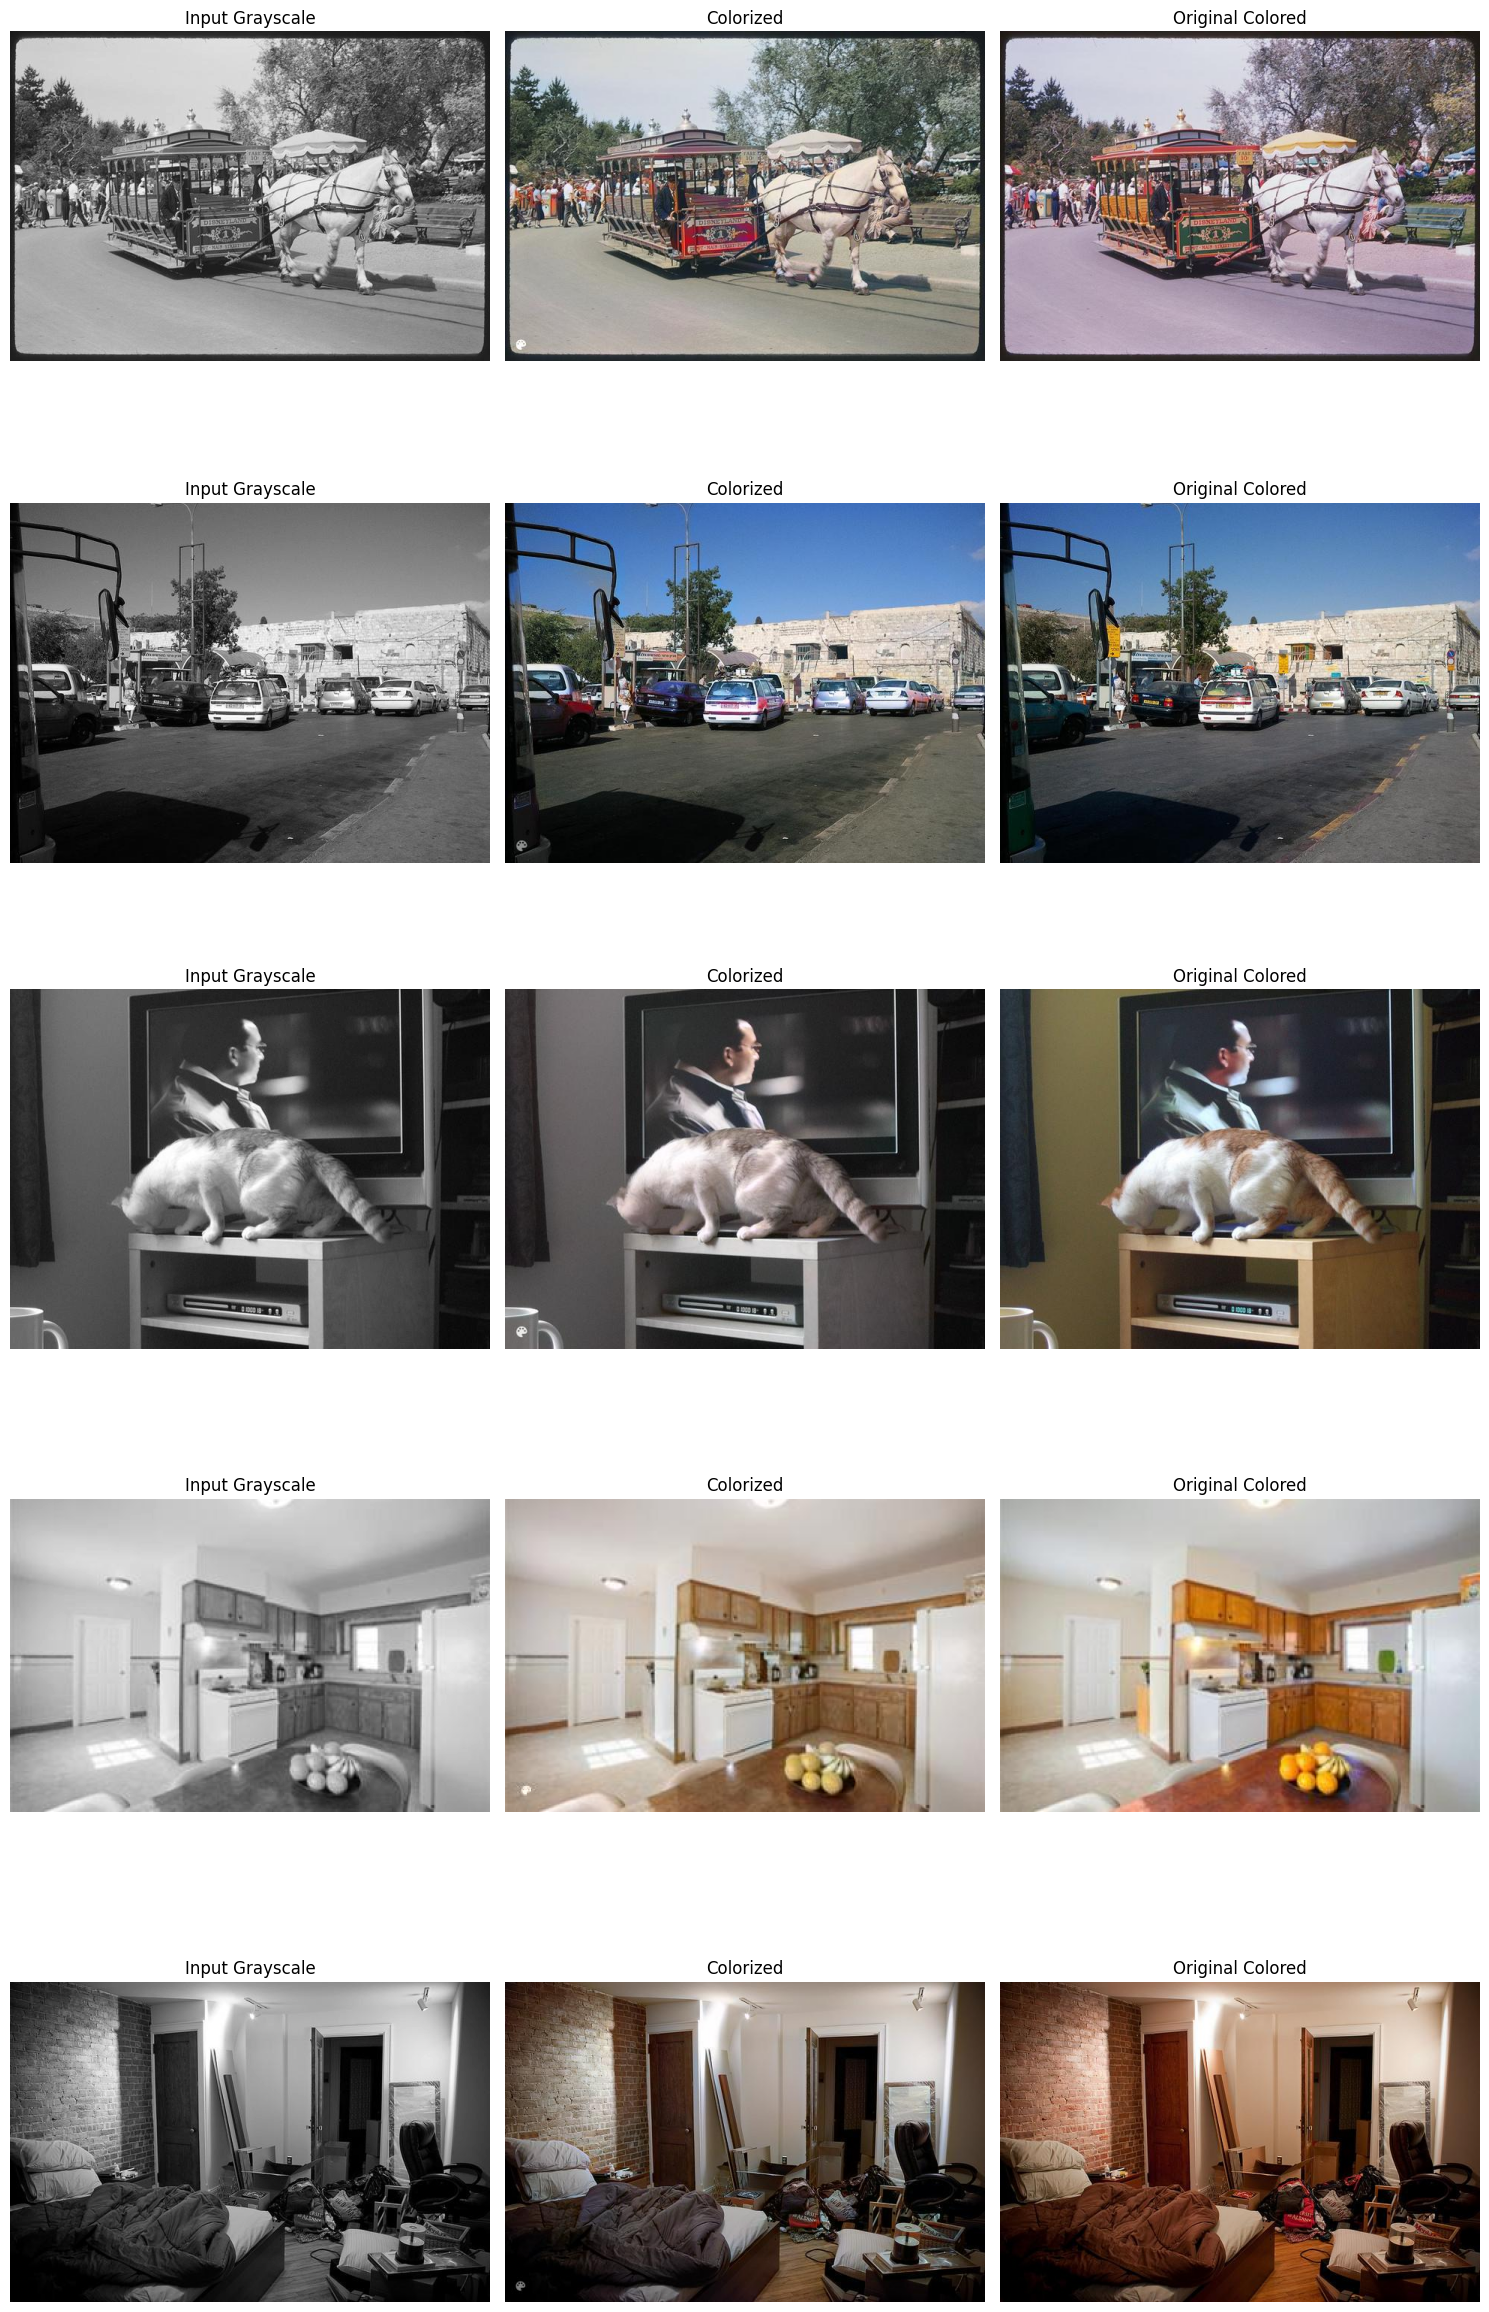

In [ ]:
# Compare images: Grayscale, Colorized, and Original
def visualize_comparison(grayscale_dir, colorized_dir, original_dir, num_images=5):
    gray_images = sorted(os.listdir(grayscale_dir))
    colorized_images = sorted(os.listdir(colorized_dir))
    original_images = sorted(os.listdir(original_dir))

    num_images = min(num_images, len(gray_images), len(colorized_images), len(original_images))

    plt.figure(figsize=(15, 5 * num_images))

    for i in range(num_images):
        # Paths
        gray_path = os.path.join(grayscale_dir, gray_images[i])
        colorized_path = os.path.join(colorized_dir, colorized_images[i])
        original_path = os.path.join(original_dir, original_images[i])

        # Load images
        gray_img = plt.imread(gray_path)
        colorized_img = plt.imread(colorized_path)
        original_img = plt.imread(original_path)

        # Plot grayscale image
        plt.subplot(num_images, 3, i * 3 + 1)
        plt.imshow(gray_img, cmap="gray")
        plt.axis("off")
        plt.title("Input Grayscale")

        # Plot colorized image
        plt.subplot(num_images, 3, i * 3 + 2)
        plt.imshow(colorized_img)
        plt.axis("off")
        plt.title("Colorized")

        # Plot original colored image
        plt.subplot(num_images, 3, i * 3 + 3)
        plt.imshow(original_img)
        plt.axis("off")
        plt.title("Original Colored")

    plt.tight_layout()
    plt.show()

# Visualize the first 5 images
visualize_comparison(gray_dir, colorized_dir, original_color_dir, num_images=5)

**Summary Highlights**

* Color Accuracy:

  * Colorized images closely resemble the originals, with major objects like trams, cars, and wooden cabinets showing realistic colors.
  * Some areas, such as skies and grass, lack vibrancy compared to the original.

* Semantic Understanding:

  * The model effectively understands objects and context, applying appropriate colors (e.g., cat fur and vehicles).
  * Background details and intricate textures are less consistent
  in complex scenes.

* Texture and Scene Coherence:

  * Outputs retain texture and overall scene coherence, with minimal color bleeding.
  * Shadows and brightness transitions are not always accurate in low-contrast areas.

* Strengths and Limitations:

  * Strengths: Handles distinct objects and simple scenes well.
  * Limitations: Struggles with complex lighting, fine details, and subtle gradients.

### **Metric-based Evaluation**

Objective evaluation using numerical metrics to quantify the quality of colorized images compared to their original counterparts.
Common metrics:
* Peak Signal-to-Noise Ratio (PSNR): Measures the fidelity of the colorized image by comparing its pixel-by-pixel difference with the original image. Higher PSNR indicates better quality.
* Structural Similarity Index (SSIM): Evaluates the perceptual similarity between the colorized and original images by considering luminance, contrast, and structural patterns. Higher SSIM reflects greater similarity.

Numerical metrics provide an unbiased and reproducible way to measure the accuracy of the model’s outputs, especially for large datasets.

In [60]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# Directories for colorized and original images
colorized_dir = "/content/train/colorized_images"
original_dir = "/content/train/color"

# Function to filter image files
def get_image_files(directory):
    valid_extensions = {".jpg", ".jpeg", ".png", ".bmp", ".tiff"}
    return [file for file in os.listdir(directory) if os.path.splitext(file)[1].lower() in valid_extensions]

# Get filtered lists of image files
colorized_images = sorted(get_image_files(colorized_dir))
original_images = sorted(get_image_files(original_dir))

# Initialize lists to store results
results = []

# Define a suitable `win_size` for SSIM
win_size = 7

if len(colorized_images) != len(original_images):
    print("Mismatch in the number of images between colorized and original directories.")
    print("Colorized folder has extra files:", set(colorized_images) - set(original_images))
    print("Original folder has extra files:", set(original_images) - set(colorized_images))
else:
    for colorized_file, original_file in zip(colorized_images, original_images):
        colorized_path = os.path.join(colorized_dir, colorized_file)
        original_path = os.path.join(original_dir, original_file)

        # Read the images
        colorized_img = cv2.imread(colorized_path)
        original_img = cv2.imread(original_path)

        if colorized_img is None or original_img is None:
            print(f"Could not read {colorized_file} or {original_file}. Skipping.")
            continue

        # Ensure the images are the same shape
        if colorized_img.shape != original_img.shape:
            print(f"Shape mismatch for {colorized_file} and {original_file}. Skipping.")
            continue

        # Ensure the images are large enough for SSIM calculation
        if min(colorized_img.shape[:2]) < win_size or min(original_img.shape[:2]) < win_size:
            print(f"Image {colorized_file} or {original_file} is too small for SSIM calculation. Skipping.")
            continue

        # Calculate PSNR and SSIM
        psnr_value = psnr(original_img, colorized_img, data_range=255)
        ssim_value = ssim(original_img, colorized_img, channel_axis=-1, win_size=win_size, data_range=255)

        # Append results
        results.append({
            "Image": colorized_file,
            "PSNR": psnr_value,
            "SSIM": ssim_value
        })

# Check if any results were added
if results:
    # Create a DataFrame from the results
    df_results = pd.DataFrame(results)

    # Calculate statistics
    stats = {
        "PSNR": {
            "average": np.mean(df_results["PSNR"]),
            "median": np.median(df_results["PSNR"]),
            "min": np.min(df_results["PSNR"]),
            "max": np.max(df_results["PSNR"]),
            "90_percentile": np.percentile(df_results["PSNR"], 90),
            "95_percentile": np.percentile(df_results["PSNR"], 95),
        },
        "SSIM": {
            "average": np.mean(df_results["SSIM"]),
            "median": np.median(df_results["SSIM"]),
            "min": np.min(df_results["SSIM"]),
            "max": np.max(df_results["SSIM"]),
            "90_percentile": np.percentile(df_results["SSIM"], 90),
            "95_percentile": np.percentile(df_results["SSIM"], 95),
        }
    }

    # Save the DataFrame to a CSV file
    df_results.to_csv("psnr_ssim_results.csv", index=False)

    # Print summary statistics
    print("PSNR Statistics:")
    for key, value in stats["PSNR"].items():
        print(f"{key}: {value:.4f}")

    print("\nSSIM Statistics:")
    for key, value in stats["SSIM"].items():
        print(f"{key}: {value:.4f}")
else:
    print("No valid images to compare. Please check the directories and image files.")



PSNR Statistics:
average: 24.2161
median: 24.6140
min: 13.4551
max: 35.4204
90_percentile: 28.6277
95_percentile: 29.9090

SSIM Statistics:
average: 0.9408
median: 0.9557
min: 0.7859
max: 0.9931
90_percentile: 0.9800
95_percentile: 0.9861


**Summary Highlights:**

**PSNR Insights:**

* A good balance between noise reduction and detail preservation is evident in most images. However, a few images with lower PSNR suggest issues like color bleeding or loss of finer details.
* The high percentile values indicate the majority of the images are well-restored, with minimal perceptual differences from the originals.

**SSIM Insights:**

* Strong structural similarity across the dataset highlights the model's ability to maintain spatial and textural fidelity.
* Lower SSIM in some cases may point to challenges in capturing complex patterns or fine-grained features in certain regions.
*High upper-percentile SSIM indicates consistent performance for most images, showcasing robustness in preserving the integrity of the original structures.